In [1]:
%%bash
git clone https://github.com/jthickstun/gm-hw3
wget https://courses.cs.washington.edu/courses/cse599i/20au/resources/hw3data.tar.gz
tar -xf hw3data.tar.gz

Cloning into 'gm-hw3'...
--2025-05-16 16:50:22--  https://courses.cs.washington.edu/courses/cse599i/20au/resources/hw3data.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182109015 (174M) [application/x-gzip]
Saving to: ‘hw3data.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  368K 8m3s
    50K .......... .......... .......... .......... ..........  0%  736K 6m2s
   100K .......... .......... .......... .......... ..........  0% 32.0M 4m3s
   150K .......... .......... .......... .......... ..........  0% 1.61M 3m29s
   200K .......... .......... .......... .......... ..........  0% 1.32M 3m14s
   250K .......... .......... .......... .......... ..........  0% 87.1M 2m42s
   300K .......... .......... .......... .......... ..........  0%  100M 

In [1]:
import sys,os,signal
from time import time

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torchvision import transforms



from IPython import display

sys.path.append('gm-hw3')
import mnist, models, utils

root = 'data/'

In [2]:
def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True, 'worker_init_fn': worker_init}

train_set = mnist.MNIST(root=root, train=True, one_hot=True, transform=transforms.ToTensor(),download=True)
test_set = mnist.MNIST(root=root, train=False, one_hot=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False, **kwargs)

/home/fs01/zq84/CS6785/HW3/gm-hw3/mnist.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, int_labels = torch.load(
/home/fs01/zq84/CS6785/HW3/gm-hw3/mnist.py:5

In [3]:
seed_size = 128

g = models.Generator(seed_size).cuda()
f = models.Discriminator().cuda()

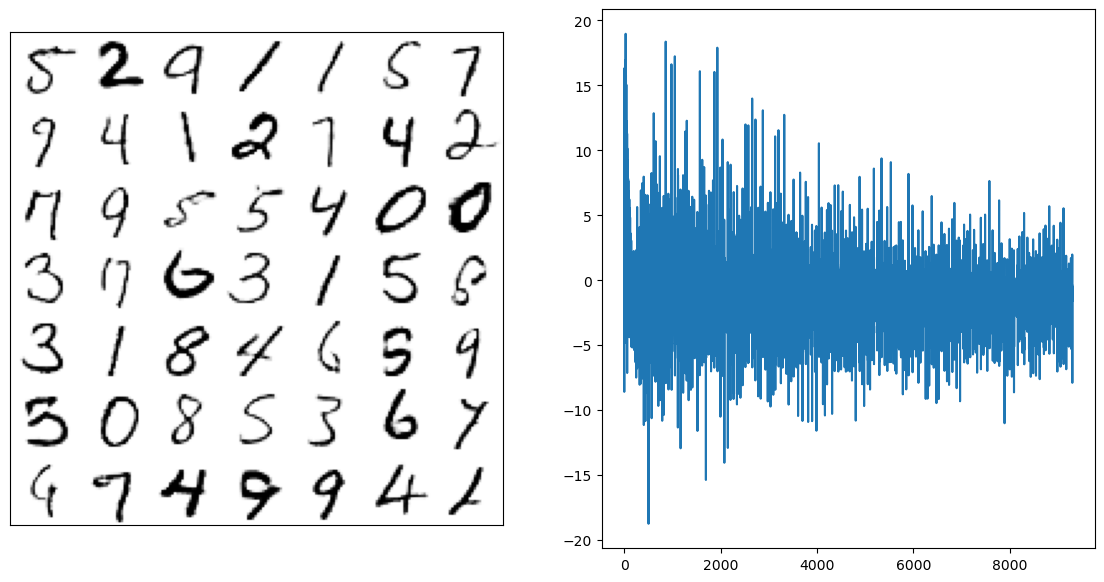

9300 4.317834377288818


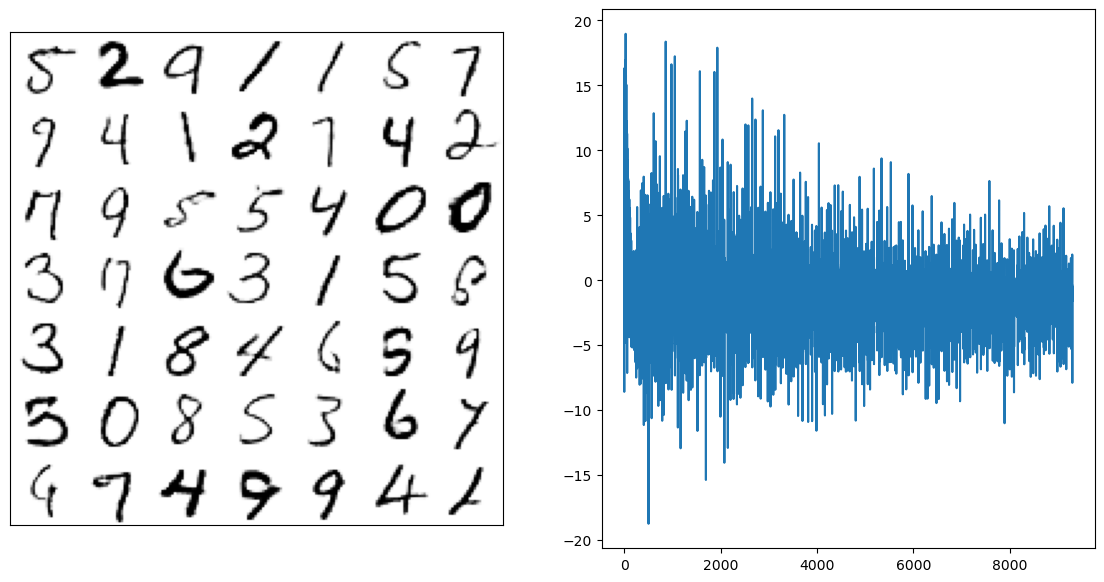

In [4]:
fig, ax = plt.subplots(1,2,figsize=(14,7))

lr = 3e-4

foptimizer = torch.optim.Adam(f.parameters(), lr=lr, betas=(0,0.9))
goptimizer = torch.optim.Adam(g.parameters(), lr=lr, betas=(0,0.9))

losses = []

i = 0
t0 = time()
scores = []
epochs = 40
for epoch in range(epochs):        
    for x,_ in train_loader:
        x = x.cuda()
        
        #
        # Problem 5: Calculate the gan updates to optimize
        #   (1) The discriminator f, using foptimizer.
        #   (2) The generator g, using goptimizer.
        #
        # Track your generator loss by appending its loss to losses.
        #

                # ----------------------------------------------------------
        # WGAN-GP update (1 critic step, 1 generator step)
        # ----------------------------------------------------------
        cur_bs = x.size(0)                              # may be < batch_size at epoch end
        z = torch.randn(cur_bs, seed_size, device=x.device)
        fake = g(z)

        # ----- 1) critic (discriminator) update -----
        foptimizer.zero_grad(set_to_none=True)

        real_score = f(x).view(-1)                      # f outputs raw scores
        fake_score = f(fake.detach()).view(-1)          # detach so g isn't hit

        # Wasserstein critic loss (maximize real−fake ⇒ minimize fake−real)
        wasserstein = fake_score.mean() - real_score.mean()

        # gradient penalty (λ = 10)
        gp = 10.0 * models.gradient_penalty(f, x, fake.detach())
        d_loss = wasserstein + gp
        d_loss.backward()
        foptimizer.step()

        # ----- 2) generator update -----
        goptimizer.zero_grad(set_to_none=True)

        # regenerate or reuse fake; keeping the same z is fine
        g_loss = -f(fake).view(-1).mean()               # maximize critic output ⇒ minimize negative
        g_loss.backward()
        goptimizer.step()

        # track generator loss
        losses.append(g_loss.detach().cpu().numpy())

        
        
        if i % 100 == 0:
            g.eval()
            y = g(torch.randn(batch_size, seed_size).cuda())
            display.clear_output(wait=True)
            utils.print_images(y.detach().cpu().numpy(), ax[0], d=28)
            ax[1].cla(); ax[1].plot(losses)
            display.display(plt.gcf())
            print(i, time()-t0)
            g.train()
            t0 = time()
        i += 1